### Multivariate Output Stacked LSTM using Iterative Prediction

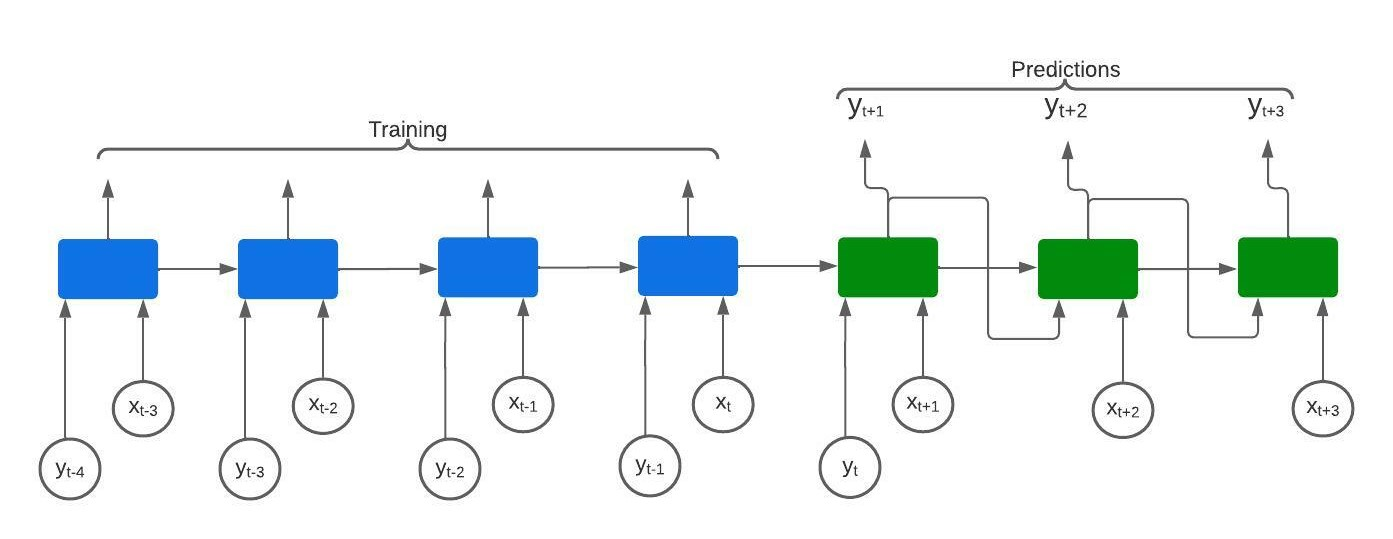

## Prediction using a standard dataset (benchmark) to investigate the usefulness of the data

Summarizing data with Pandas
- info()
- describe()
- value_counts()
- nunique()
- sum()
- count()
- min(), max(), mean(), and median()
- agg()
- groupby()

In [1]:
### I need a different dataset
from pandas import read_csv
sim_data = read_csv("waterTank.csv")
sim_data.describe()
print('The size of the data', sim_data.size)
# sim_data["wt3_valve"].value_counts()

The size of the data 107460


In [2]:
sim_data.head(10)

,time,wt3_valve,Tank1InFlow,Tank1WaterLevel,Tank2OutFlow,Tank2WaterLevel,tank2_Tank3OutFlow,tank2.level,tank2_puddle
0,0.00,0,0,1.000000e-06,0.0,0.000000e+00,0.0,0.0,0.022568
1,0.05,0,0,6.890000e-07,0.0,3.110000e-07,0.0,0.0,0.022568
2,0.10,0,1,3.333928e-03,0.0,4.050000e-07,0.0,0.0,0.022568
3,0.15,0,1,5.448433e-02,0.0,8.850002e-03,0.0,0.0,0.022568
4,0.20,0,0,7.717051e-02,0.0,2.949715e-02,0.0,0.0,0.022568
5,0.25,0,0,6.660111e-02,0.0,4.006656e-02,0.0,0.0,0.022568
6,0.30,0,0,6.073531e-02,0.0,4.593236e-02,0.0,0.0,0.022568
7,0.35,0,1,9.583037e-02,0.0,5.417063e-02,0.0,0.0,0.022568
8,0.40,0,1,1.233515e-01,0.0,6.664952e-02,0.0,0.0,0.022568
9,0.45,0,0,1.194144e-01,0.0,8.725326e-02,0.0,0.0,0.022568


In [3]:
sim_data = sim_data.values
# sim_data.head()
sim_data[:,1].size

11940

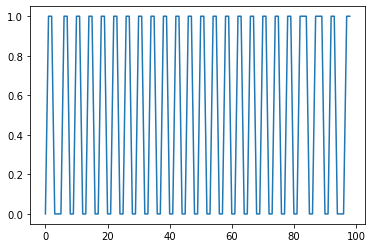

In [9]:
import matplotlib.pyplot as plt
# sim_data = sim_data.values
plt.plot(sim_data[1:100,2])
plt.show()

### Prediction with the Water Tank Simulated dataset (Iterated Strategy)

Initial shape of x_input (30, 8)
Value of yhat [[ 0.0035438   0.92421067  1.0006372   1.0156602   1.003992   -0.00854871
   0.89510334  0.39297634]]
Value of yhat [[0.00443451 0.03487747 1.0249704  1.0298408  1.0536624  0.01969941
  0.93949807 0.3656712 ]]
Value of yhat [[0.40732685 0.17873713 1.0328262  1.0500847  1.0794024  0.02557032
  1.0342058  0.37963277]]
Value of yhat [[1.0206623  0.63050157 0.9973466  1.0552747  0.991729   0.5939162
  0.9669924  0.36180955]]
Value of yhat [[1.107696   1.2009287  1.0531758  1.0858731  1.0631349  0.951558
  0.90629005 0.39312294]]
Value of yhat [[0.92408967 1.0144786  1.0145236  1.0202774  1.0057994  0.7876285
  0.78416306 0.41242307]]
Value of yhat [[0.9012401  0.13033172 0.99508387 1.0123076  1.0098087  0.73922914
  0.7863825  0.38248467]]
Value of yhat [[ 0.89560014 -0.11845877  0.99128026  1.025428    1.0057501   0.71801335
   0.78139347  0.37399065]]
Value of yhat [[0.8233872  0.48692304 0.96212924 0.99657375 0.9655943  0.71527094
  0.72816

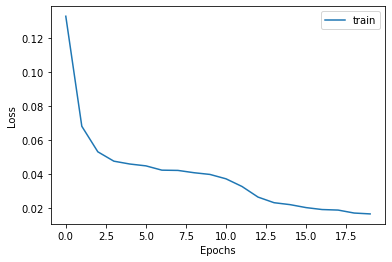

In [12]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence

# Read the data
# data = read_csv('pollution2.csv', header=0, index_col=0)
data = read_csv('waterTank.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 2000
#dataset = raw_data[0:n_train,:]
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
n_steps = 30
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.1))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=20, verbose=0)

# demonstrate iterative prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps,:]
print(f'Initial shape of x_input {x_inp.shape}')
# x_inp = array([[70,75,145], [80,85,165], [90,95,185]])
result = []
var_1, var_2, var_3, var_4, var_5, var_6, var_7, var_8 = list(), list(), list(), list(), list(), list(), list(), list()
# num_repeat = 30
num_repeat = 30
for i in range(num_repeat):
    
      x_input = x_inp.reshape((1, n_steps, n_features))
      yhat = model.predict(x_input, verbose=0)
      # inv_yhat = scaler.inverse_transform(yhat)
      var_1.append(yhat[0][0])
      var_2.append(yhat[0][1])
      var_3.append(yhat[0][2])
      var_4.append(yhat[0][3])
      var_5.append(yhat[0][4])
      var_6.append(yhat[0][5])
      var_7.append(yhat[0][6])
      var_8.append(yhat[0][7])
    
  # p = np.append(x_inp[0],yhat[0][0])[1:]
  # q = np.append(x_inp[1],yhat[0][1])[1:]
  # r = np.append(x_inp[2],yhat[0][2])[1:]
      print(f'Value of yhat {yhat}')
      result = np.append(result,yhat[0])
      x_inp = np.append(x_inp,yhat[0])
      x_inp = x_inp.reshape(1,n_steps+1,n_features)
      x_inp = x_inp[:,1:,0:]

var = DataFrame(vstack((var_1,var_2,var_3,var_4,var_5, var_6, var_7, var_8))).T
inv_var = scaler.inverse_transform(var)
print("--------------AFTER THE INVERTED SCALING-------------------")
inv_var

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

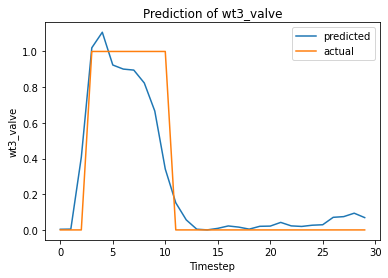

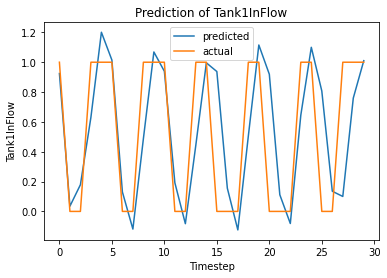

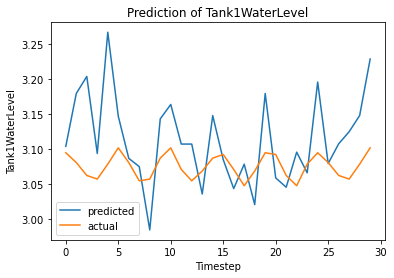

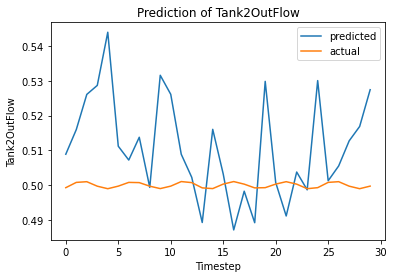

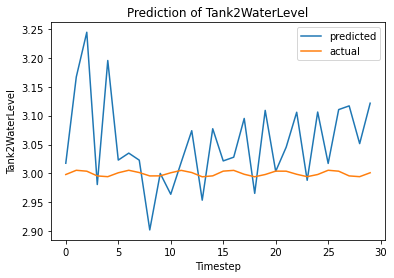

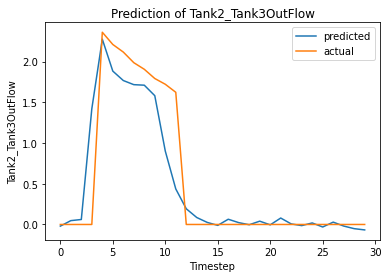

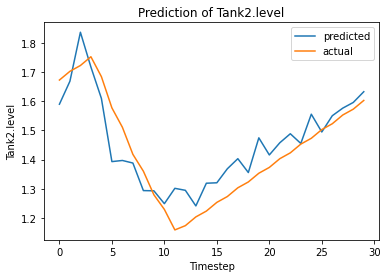

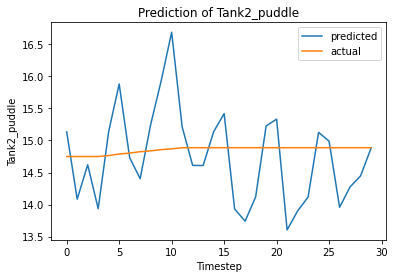

In [14]:
attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank2OutFlow", "Tank2WaterLevel", "Tank2_Tank3OutFlow", "Tank2.level", "Tank2_puddle"]
for i in range(8):
    title = "Prediction of "+str(attr[i])
    actual = raw_data[2030:2060,i]
    pred = inv_var.T
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(attr[i])
    plt.plot(pred[i], label="predicted")
    plt.plot(actual, label="actual")
    plt.legend()
    plt.show()

### Prediction with the Water Tank Simulated dataset (Direct Strategy)

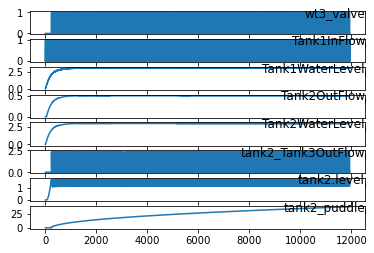

In [15]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('waterTank.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

The shape of the raw_data before scaling is (11940, 8)
Epoch 1/200
26/26 - 6s - loss: 0.1601 - 6s/epoch - 249ms/step
Epoch 2/200
26/26 - 4s - loss: 0.0812 - 4s/epoch - 151ms/step
Epoch 3/200
26/26 - 4s - loss: 0.0779 - 4s/epoch - 152ms/step
Epoch 4/200
26/26 - 4s - loss: 0.0753 - 4s/epoch - 150ms/step
Epoch 5/200
26/26 - 4s - loss: 0.0733 - 4s/epoch - 159ms/step
Epoch 6/200
26/26 - 4s - loss: 0.0721 - 4s/epoch - 151ms/step
Epoch 7/200
26/26 - 4s - loss: 0.0713 - 4s/epoch - 150ms/step
Epoch 8/200
26/26 - 4s - loss: 0.0702 - 4s/epoch - 151ms/step
Epoch 9/200
26/26 - 4s - loss: 0.0697 - 4s/epoch - 159ms/step
Epoch 10/200
26/26 - 4s - loss: 0.0690 - 4s/epoch - 151ms/step
Epoch 11/200
26/26 - 4s - loss: 0.0686 - 4s/epoch - 150ms/step
Epoch 12/200
26/26 - 4s - loss: 0.0683 - 4s/epoch - 150ms/step
Epoch 13/200
26/26 - 4s - loss: 0.0680 - 4s/epoch - 153ms/step
Epoch 14/200
26/26 - 4s - loss: 0.0680 - 4s/epoch - 158ms/step
Epoch 15/200
26/26 - 4s - loss: 0.0676 - 4s/epoch - 161ms/step
Epoch 16/

Epoch 130/200
26/26 - 5s - loss: 0.0529 - 5s/epoch - 201ms/step
Epoch 131/200
26/26 - 5s - loss: 0.0515 - 5s/epoch - 206ms/step
Epoch 132/200
26/26 - 5s - loss: 0.0514 - 5s/epoch - 203ms/step
Epoch 133/200
26/26 - 5s - loss: 0.0536 - 5s/epoch - 204ms/step
Epoch 134/200
26/26 - 5s - loss: 0.0569 - 5s/epoch - 200ms/step
Epoch 135/200
26/26 - 5s - loss: 0.0605 - 5s/epoch - 196ms/step
Epoch 136/200
26/26 - 5s - loss: 0.0533 - 5s/epoch - 200ms/step
Epoch 137/200
26/26 - 5s - loss: 0.0552 - 5s/epoch - 206ms/step
Epoch 138/200
26/26 - 5s - loss: 0.0540 - 5s/epoch - 205ms/step
Epoch 139/200
26/26 - 5s - loss: 0.0533 - 5s/epoch - 211ms/step
Epoch 140/200
26/26 - 5s - loss: 0.0521 - 5s/epoch - 203ms/step
Epoch 141/200
26/26 - 5s - loss: 0.0506 - 5s/epoch - 198ms/step
Epoch 142/200
26/26 - 5s - loss: 0.0501 - 5s/epoch - 201ms/step
Epoch 143/200
26/26 - 5s - loss: 0.0504 - 5s/epoch - 211ms/step
Epoch 144/200
26/26 - 5s - loss: 0.0520 - 5s/epoch - 198ms/step
Epoch 145/200
26/26 - 5s - loss: 0.0550 

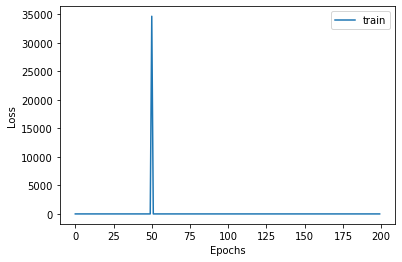

In [24]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, RepeatVector, TimeDistributed
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence

# Read the data
data = read_csv('waterTank.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 1000
#dataset = raw_data[0:n_train,:]
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
n_steps_in, n_steps_out = 100, 100
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=200, verbose=2, shuffle=False)

# demonstrate Direct prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps_in,:]
print(f'Initial shape of x_input {x_inp.shape}')
x_input = x_inp.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(f'The shape of yhat after prediction is {yhat.shape}')
yhat = yhat.reshape(n_steps_out, n_features)
print(f'The new shape of yhat  is {yhat.shape}')
inv_yhat = scaler.inverse_transform(yhat)
print(inv_yhat)

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

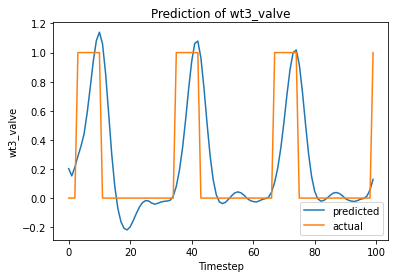

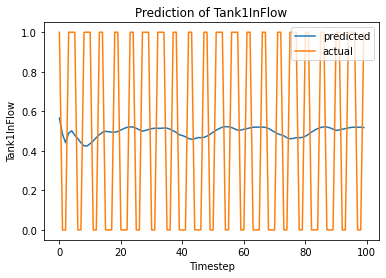

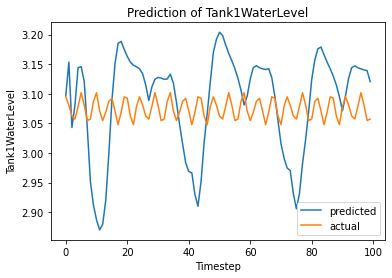

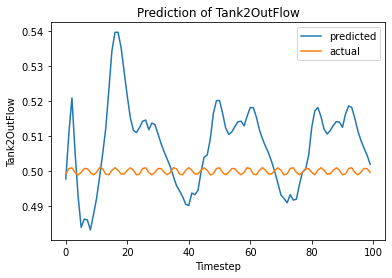

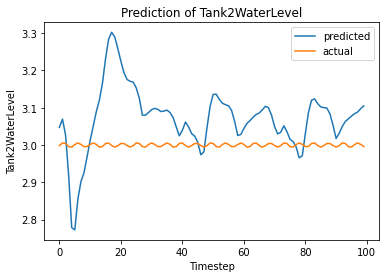

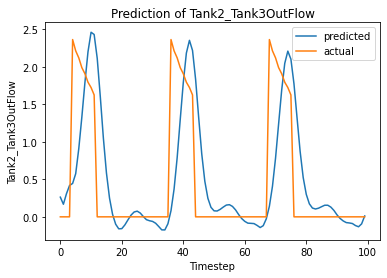

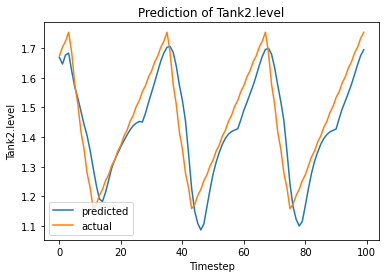

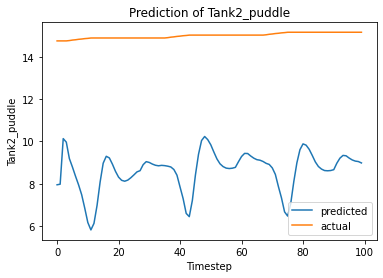

In [25]:
attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank2OutFlow", "Tank2WaterLevel", "Tank2_Tank3OutFlow", "Tank2.level", "Tank2_puddle"]
for i in range(8):
    title = "Prediction of "+str(attr[i])
    actual = raw_data[2030:2130,i]
    pred = inv_yhat.T
#     pred = inv_yhat
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(attr[i])
    plt.plot(pred[i], label="predicted")
    plt.plot(actual, label="actual")
    plt.legend()
    plt.show()